In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip

In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip


In [ ]:
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/resnet-50_best_model.log'
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/resnet-50_ep30_lr=0001_best_model.pth'

In [ ]:
from torchvision import datasets, models, transforms
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping="", is_pt=False):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)
        self.is_pt = is_pt


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        label = self.id_to_label[str(image_id)]

        if self.is_pt:
            tensor = torch.load(image_path)
            if self.transform:
                tensor = self.transform(tensor)
            return tensor, label
        else:
            # Load the image
            image = Image.open(image_path)
            # Apply transform if any
            if self.transform:
                image = self.transform(image)
            return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_pt = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
# train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping.csv"
train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping_drive.csv" # "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_pt_id_to_path_mapping.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)



In [ ]:
len(train_dataset)

6731

In [ ]:
class RunningAverage:
    '''
      Computes and keeps track of the running average and the current value of metrics
    '''
    def __init__(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculates the simplified Global Average Precision.
    https://www.kaggle.com/competitions/landmark-recognition-2020/overview/evaluation

    Args:
        predicts (torch.Tensor): Predicted labels of shape (n_samples,).
        confs (torch.Tensor): Confidence scores associated with predictions, of shape (n_samples,).
        targets (torch.Tensor): Ground truth labels, of shape (n_samples,).

    Returns:
        float: The GAP score for the given predictions and targets.
    """
    assert len(predicts.shape) == 1 and len(confs.shape) == 1 and len(targets.shape) == 1 and predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0]
    return res

# Model Initialization

In [ ]:
from torchvision import models
import torch

def initialize_model(num_classes):
    # Load a pretrained ResNet-18 model
    model = models.resnet50(pretrained=True)
    # Modify the final layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    return model

# Determine the number of unique classes
num_classes = len(set(train_dataset.id_to_label.values()))

# num_classes=2000
print(f"number of classes {num_classes}")
model = initialize_model(num_classes=num_classes)



number of classes 25


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


# Model Finetuning

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, loss_fn, optimizer, device, epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    train_gap = []
    best_train_loss = float('inf')
    best_score = float('-inf')
    for epoch in range(epochs):
        model.train()
        avg_score = RunningAverage()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Wrap the training loop with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            confs, predicts = torch.max(outputs.detach(), dim=1)
            avg_score.update(GAP(predicts, confs, labels))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with current loss and accuracy
            progress_bar.set_postfix(loss=f'{running_loss / total_samples:.4f}', acc=f'{(correct_predictions.double() / total_samples * 100):.2f}%', gap=f'{avg_score.avg:.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_gap.append(avg_score.avg)


        # Save the best model if the training loss has improved
        if epoch_loss < best_train_loss and avg_score.avg > best_score:
            best_score = avg_score.avg
            best_train_loss = epoch_loss
            torch.save(model.state_dict(), MODEL_SAVE_TO)
            print(f'Saved best model with Train Loss: {epoch_loss}, GAP score: {round(best_score, 4)}')

    return train_losses, train_gap, train_accuracies



In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for the training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Title and grid
    plt.title('Training Loss and Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')  # Position the legend in the center right

    plt.show()



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

CUDA USED


In [ ]:
# Initialize the model, optimizer, and loss function
model = initialize_model(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Move the model to the appropriate device
model.to(device)

# Train the model
train_losses, train_gap, train_accuracies = train_model(model, train_loader, loss_fn, optimizer, device, epochs=30)

Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/30: 100%|██████████| 421/421 [00:29<00:00, 14.49it/s, acc=31.54%, gap=0.2526, loss=0.1516]


Saved best model with Train Loss: 2.423820955736337, GAP score: 0.2526


Epoch 2/30: 100%|██████████| 421/421 [00:27<00:00, 15.54it/s, acc=43.59%, gap=0.3612, loss=0.1198]


Saved best model with Train Loss: 1.9148467345928637, GAP score: 0.3612


Epoch 3/30: 100%|██████████| 421/421 [00:26<00:00, 15.61it/s, acc=49.58%, gap=0.4234, loss=0.1060]


Saved best model with Train Loss: 1.6942997763105923, GAP score: 0.4234


Epoch 4/30: 100%|██████████| 421/421 [00:27<00:00, 15.50it/s, acc=52.18%, gap=0.4485, loss=0.0998]


Saved best model with Train Loss: 1.595367201008876, GAP score: 0.4485


Epoch 5/30: 100%|██████████| 421/421 [00:27<00:00, 15.34it/s, acc=55.59%, gap=0.4865, loss=0.0922]


Saved best model with Train Loss: 1.4737115631194126, GAP score: 0.4865


Epoch 6/30: 100%|██████████| 421/421 [00:26<00:00, 15.65it/s, acc=57.82%, gap=0.5127, loss=0.0878]


Saved best model with Train Loss: 1.4033733401049344, GAP score: 0.5127


Epoch 7/30: 100%|██████████| 421/421 [00:27<00:00, 15.51it/s, acc=59.13%, gap=0.5258, loss=0.0841]


Saved best model with Train Loss: 1.3452984054977708, GAP score: 0.5258


Epoch 8/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=60.54%, gap=0.5461, loss=0.0817]


Saved best model with Train Loss: 1.3069329829510488, GAP score: 0.5461


Epoch 9/30: 100%|██████████| 421/421 [00:27<00:00, 15.35it/s, acc=62.93%, gap=0.5732, loss=0.0765]


Saved best model with Train Loss: 1.2236901063675552, GAP score: 0.5732


Epoch 10/30: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s, acc=63.65%, gap=0.5809, loss=0.0745]


Saved best model with Train Loss: 1.1916925554603974, GAP score: 0.5809


Epoch 11/30: 100%|██████████| 421/421 [00:26<00:00, 15.60it/s, acc=64.27%, gap=0.5878, loss=0.0721]


Saved best model with Train Loss: 1.1534419223984744, GAP score: 0.5878


Epoch 12/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=65.43%, gap=0.6026, loss=0.0697]


Saved best model with Train Loss: 1.1149355544755124, GAP score: 0.6026


Epoch 13/30: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s, acc=67.43%, gap=0.6262, loss=0.0658]


Saved best model with Train Loss: 1.0523063256593328, GAP score: 0.6262


Epoch 14/30: 100%|██████████| 421/421 [00:27<00:00, 15.42it/s, acc=68.91%, gap=0.6393, loss=0.0639]


Saved best model with Train Loss: 1.0208547182575824, GAP score: 0.6393


Epoch 15/30: 100%|██████████| 421/421 [00:27<00:00, 15.46it/s, acc=70.48%, gap=0.6562, loss=0.0608]


Saved best model with Train Loss: 0.9720785988764639, GAP score: 0.6562


Epoch 16/30: 100%|██████████| 421/421 [00:26<00:00, 15.64it/s, acc=70.51%, gap=0.6603, loss=0.0587]


Saved best model with Train Loss: 0.9385589140681926, GAP score: 0.6603


Epoch 17/30: 100%|██████████| 421/421 [00:27<00:00, 15.46it/s, acc=72.07%, gap=0.6750, loss=0.0563]


Saved best model with Train Loss: 0.9004620736610861, GAP score: 0.675


Epoch 18/30: 100%|██████████| 421/421 [00:27<00:00, 15.21it/s, acc=73.05%, gap=0.6936, loss=0.0535]


Saved best model with Train Loss: 0.8550123014883304, GAP score: 0.6936


Epoch 19/30: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s, acc=74.02%, gap=0.6997, loss=0.0516]


Saved best model with Train Loss: 0.8252178852461862, GAP score: 0.6997


Epoch 20/30: 100%|██████████| 421/421 [00:27<00:00, 15.22it/s, acc=74.65%, gap=0.7055, loss=0.0500]


Saved best model with Train Loss: 0.7994936115668109, GAP score: 0.7055


Epoch 21/30: 100%|██████████| 421/421 [00:27<00:00, 15.55it/s, acc=76.50%, gap=0.7279, loss=0.0474]


Saved best model with Train Loss: 0.7584014815630086, GAP score: 0.7279


Epoch 22/30: 100%|██████████| 421/421 [00:26<00:00, 15.63it/s, acc=76.87%, gap=0.7322, loss=0.0458]


Saved best model with Train Loss: 0.7320372234684838, GAP score: 0.7322


Epoch 23/30: 100%|██████████| 421/421 [00:27<00:00, 15.51it/s, acc=78.07%, gap=0.7463, loss=0.0436]


Saved best model with Train Loss: 0.6978342909003097, GAP score: 0.7463


Epoch 24/30: 100%|██████████| 421/421 [00:27<00:00, 15.53it/s, acc=78.34%, gap=0.7469, loss=0.0422]


Saved best model with Train Loss: 0.6749923182142602, GAP score: 0.7469


Epoch 25/30: 100%|██████████| 421/421 [00:26<00:00, 15.79it/s, acc=79.66%, gap=0.7636, loss=0.0396]


Saved best model with Train Loss: 0.6331612254335874, GAP score: 0.7636


Epoch 26/30: 100%|██████████| 421/421 [00:26<00:00, 15.68it/s, acc=80.72%, gap=0.7744, loss=0.0384]


Saved best model with Train Loss: 0.6132596838962721, GAP score: 0.7744


Epoch 27/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=82.38%, gap=0.7957, loss=0.0341]


Saved best model with Train Loss: 0.5453033177912093, GAP score: 0.7957


Epoch 29/30: 100%|██████████| 421/421 [00:27<00:00, 15.34it/s, acc=83.45%, gap=0.8072, loss=0.0317]


Saved best model with Train Loss: 0.506281643628083, GAP score: 0.8072


Epoch 30/30: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s, acc=84.10%, gap=0.8129, loss=0.0312]


Saved best model with Train Loss: 0.4993355141293408, GAP score: 0.8129


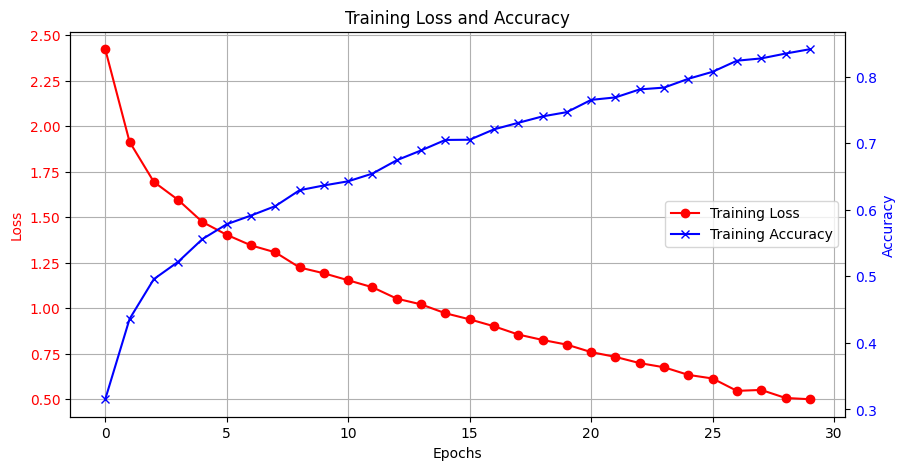

maximum accuracy achieved with 84.1034% at epoch 30


In [ ]:
# Plot losses
import numpy as np
acc = [acc.item() for acc in train_accuracies]
plot_metrics(train_losses, acc)
print(f"maximum accuracy achieved with {round(max(acc), 6) * 100}% at epoch {np.argmax(acc) + 1}")

In [ ]:
import json

data = {
    "train_loss": train_losses,
    "train_accuracy": acc,
    "train_gap": train_gap
}

with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)


# Test and Eavluation

In [ ]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=False)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [ ]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)

model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_TO))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


NameError: name 'model' is not defined

# More Experiments

In [ ]:
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_resnet-50.log'
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/ablation_resnet-50.pth'

In [ ]:
from tqdm import tqdm
def train_and_evaluate_model(
    model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10, model_save_path="best_model.pth"
):
    model.to(device)
    train_losses = []
    train_accuracies = []
    train_gap = []
    test_accuracies = []
    best_test_accuracy = float("-inf")

    for epoch in range(epochs):
        model.train()
        avg_score = RunningAverage()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            confs, predicts = torch.max(outputs.detach(), dim=1)
            avg_score.update(GAP(predicts, confs, labels))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            progress_bar.set_postfix(
                loss=f"{running_loss / total_samples:.4f}",
                acc=f"{(correct_predictions.double() / total_samples * 100):.2f}%",
                gap=f"{avg_score.avg:.4f}"
            )

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_gap.append(avg_score.avg)

        # Evaluate on the test dataset
        model.eval()
        correct_predictions_test = 0
        total_samples_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct_predictions_test += torch.sum(preds == labels.data)
                total_samples_test += labels.size(0)

        test_acc = correct_predictions_test.double() / total_samples_test
        test_accuracies.append(test_acc)

        # Print epoch results and save the best model if performance improved
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}, Test Acc: {test_acc:.2f}")

        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with Test Accuracy: {test_acc:.2f}")

    return train_losses, train_gap, train_accuracies, test_accuracies


In [ ]:
model = initialize_model(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)

model.to(device)

CUDA USED


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_losses, train_gap, train_accuracies, test_acc_hist = train_and_evaluate_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=30, model_save_path=MODEL_SAVE_TO)

Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/30: 100%|██████████| 421/421 [00:28<00:00, 14.55it/s, acc=39.43%, gap=0.3181, loss=0.1321]


Epoch 1/30: Train Loss: 2.1124, Train Acc: 0.39, Test Acc: 0.51
Saved best model with Test Accuracy: 0.51


Epoch 2/30: 100%|██████████| 421/421 [00:27<00:00, 15.50it/s, acc=50.36%, gap=0.4220, loss=0.1050]


Epoch 2/30: Train Loss: 1.6791, Train Acc: 0.50, Test Acc: 0.54
Saved best model with Test Accuracy: 0.54


Epoch 3/30: 100%|██████████| 421/421 [00:26<00:00, 15.69it/s, acc=55.40%, gap=0.4798, loss=0.0933]


Epoch 3/30: Train Loss: 1.4918, Train Acc: 0.55, Test Acc: 0.55
Saved best model with Test Accuracy: 0.55


Epoch 4/30: 100%|██████████| 421/421 [00:26<00:00, 15.66it/s, acc=58.67%, gap=0.5208, loss=0.0868]


Epoch 4/30: Train Loss: 1.3885, Train Acc: 0.59, Test Acc: 0.61
Saved best model with Test Accuracy: 0.61


Epoch 5/30: 100%|██████████| 421/421 [00:27<00:00, 15.41it/s, acc=61.00%, gap=0.5476, loss=0.0817]


Epoch 5/30: Train Loss: 1.3058, Train Acc: 0.61, Test Acc: 0.60


Epoch 6/30: 100%|██████████| 421/421 [00:27<00:00, 15.49it/s, acc=62.83%, gap=0.5697, loss=0.0769]


Epoch 6/30: Train Loss: 1.2301, Train Acc: 0.63, Test Acc: 0.59


Epoch 7/30: 100%|██████████| 421/421 [00:26<00:00, 15.65it/s, acc=64.58%, gap=0.5858, loss=0.0735]


Epoch 7/30: Train Loss: 1.1746, Train Acc: 0.65, Test Acc: 0.64
Saved best model with Test Accuracy: 0.64


Epoch 8/30: 100%|██████████| 421/421 [00:27<00:00, 15.46it/s, acc=65.59%, gap=0.5994, loss=0.0702]


Epoch 8/30: Train Loss: 1.1229, Train Acc: 0.66, Test Acc: 0.63


Epoch 9/30: 100%|██████████| 421/421 [00:27<00:00, 15.56it/s, acc=66.53%, gap=0.6027, loss=0.0690]


Epoch 9/30: Train Loss: 1.1027, Train Acc: 0.67, Test Acc: 0.64
Saved best model with Test Accuracy: 0.64


Epoch 10/30: 100%|██████████| 421/421 [00:26<00:00, 15.63it/s, acc=67.94%, gap=0.6220, loss=0.0653]


Epoch 10/30: Train Loss: 1.0433, Train Acc: 0.68, Test Acc: 0.66
Saved best model with Test Accuracy: 0.66


Epoch 11/30: 100%|██████████| 421/421 [00:27<00:00, 15.35it/s, acc=70.27%, gap=0.6545, loss=0.0614]


Epoch 11/30: Train Loss: 0.9815, Train Acc: 0.70, Test Acc: 0.65


Epoch 12/30: 100%|██████████| 421/421 [00:27<00:00, 15.42it/s, acc=70.72%, gap=0.6587, loss=0.0590]


Epoch 12/30: Train Loss: 0.9439, Train Acc: 0.71, Test Acc: 0.65


Epoch 13/30: 100%|██████████| 421/421 [00:27<00:00, 15.29it/s, acc=71.98%, gap=0.6722, loss=0.0566]


Epoch 13/30: Train Loss: 0.9053, Train Acc: 0.72, Test Acc: 0.67
Saved best model with Test Accuracy: 0.67


Epoch 14/30: 100%|██████████| 421/421 [00:26<00:00, 15.62it/s, acc=73.26%, gap=0.6897, loss=0.0532]


Epoch 14/30: Train Loss: 0.8508, Train Acc: 0.73, Test Acc: 0.65


Epoch 15/30: 100%|██████████| 421/421 [00:27<00:00, 15.54it/s, acc=73.76%, gap=0.6923, loss=0.0518]


Epoch 15/30: Train Loss: 0.8283, Train Acc: 0.74, Test Acc: 0.68
Saved best model with Test Accuracy: 0.68


Epoch 16/30: 100%|██████████| 421/421 [00:27<00:00, 15.52it/s, acc=74.73%, gap=0.7040, loss=0.0495]


Epoch 16/30: Train Loss: 0.7912, Train Acc: 0.75, Test Acc: 0.67


Epoch 17/30: 100%|██████████| 421/421 [00:26<00:00, 15.67it/s, acc=76.79%, gap=0.7270, loss=0.0461]


Epoch 17/30: Train Loss: 0.7369, Train Acc: 0.77, Test Acc: 0.66


Epoch 18/30: 100%|██████████| 421/421 [00:26<00:00, 15.61it/s, acc=77.33%, gap=0.7359, loss=0.0444]


Epoch 18/30: Train Loss: 0.7092, Train Acc: 0.77, Test Acc: 0.68


Epoch 19/30: 100%|██████████| 421/421 [00:27<00:00, 15.46it/s, acc=78.13%, gap=0.7432, loss=0.0433]


Epoch 19/30: Train Loss: 0.6919, Train Acc: 0.78, Test Acc: 0.68


Epoch 20/30: 100%|██████████| 421/421 [00:26<00:00, 15.62it/s, acc=79.42%, gap=0.7583, loss=0.0413]


Epoch 20/30: Train Loss: 0.6603, Train Acc: 0.79, Test Acc: 0.68


Epoch 21/30: 100%|██████████| 421/421 [00:27<00:00, 15.49it/s, acc=80.69%, gap=0.7744, loss=0.0383]


Epoch 21/30: Train Loss: 0.6129, Train Acc: 0.81, Test Acc: 0.68


Epoch 22/30: 100%|██████████| 421/421 [00:27<00:00, 15.46it/s, acc=81.55%, gap=0.7849, loss=0.0356]


Epoch 22/30: Train Loss: 0.5685, Train Acc: 0.82, Test Acc: 0.70
Saved best model with Test Accuracy: 0.70


Epoch 23/30: 100%|██████████| 421/421 [00:27<00:00, 15.41it/s, acc=82.56%, gap=0.7947, loss=0.0342]


Epoch 23/30: Train Loss: 0.5468, Train Acc: 0.83, Test Acc: 0.69


Epoch 24/30: 100%|██████████| 421/421 [00:27<00:00, 15.50it/s, acc=81.93%, gap=0.7875, loss=0.0350]


Epoch 24/30: Train Loss: 0.5599, Train Acc: 0.82, Test Acc: 0.67


Epoch 25/30: 100%|██████████| 421/421 [00:27<00:00, 15.52it/s, acc=82.23%, gap=0.7908, loss=0.0345]


Epoch 25/30: Train Loss: 0.5512, Train Acc: 0.82, Test Acc: 0.71
Saved best model with Test Accuracy: 0.71


Epoch 26/30: 100%|██████████| 421/421 [00:27<00:00, 15.37it/s, acc=85.46%, gap=0.8291, loss=0.0287]


Epoch 26/30: Train Loss: 0.4582, Train Acc: 0.85, Test Acc: 0.70


Epoch 27/30: 100%|██████████| 421/421 [00:26<00:00, 15.74it/s, acc=85.37%, gap=0.8302, loss=0.0276]


Epoch 27/30: Train Loss: 0.4417, Train Acc: 0.85, Test Acc: 0.72
Saved best model with Test Accuracy: 0.72


Epoch 28/30: 100%|██████████| 421/421 [00:27<00:00, 15.56it/s, acc=86.81%, gap=0.8453, loss=0.0252]


Epoch 28/30: Train Loss: 0.4022, Train Acc: 0.87, Test Acc: 0.73
Saved best model with Test Accuracy: 0.73


Epoch 29/30: 100%|██████████| 421/421 [00:27<00:00, 15.42it/s, acc=86.82%, gap=0.8448, loss=0.0246]


Epoch 29/30: Train Loss: 0.3933, Train Acc: 0.87, Test Acc: 0.69


Epoch 30/30: 100%|██████████| 421/421 [00:27<00:00, 15.35it/s, acc=87.86%, gap=0.8566, loss=0.0234]


Epoch 30/30: Train Loss: 0.3746, Train Acc: 0.88, Test Acc: 0.70


# Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_acc(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 6))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Create a third y-axis using a new set of axes positioned to the right
    ax3 = ax1.twinx()  # New axis that shares x-axis
    ax3.spines['right'].set_position(('outward', 60))  # Move the third axis out to avoid overlap
    line3, = ax3.plot(test_accuracies, label='Test Accuracy', color='green', marker='s')
    ax3.set_ylabel('Test Accuracy', color='green')  # Set y-axis label for test accuracy
    ax3.tick_params(axis='y', labelcolor='green')  # Set the color of y-axis ticks to green

    # Title and grid
    plt.title('ResNet-50: Training Loss, Training Accuracy, and Test Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)  # Adjust legend position

    plt.show()


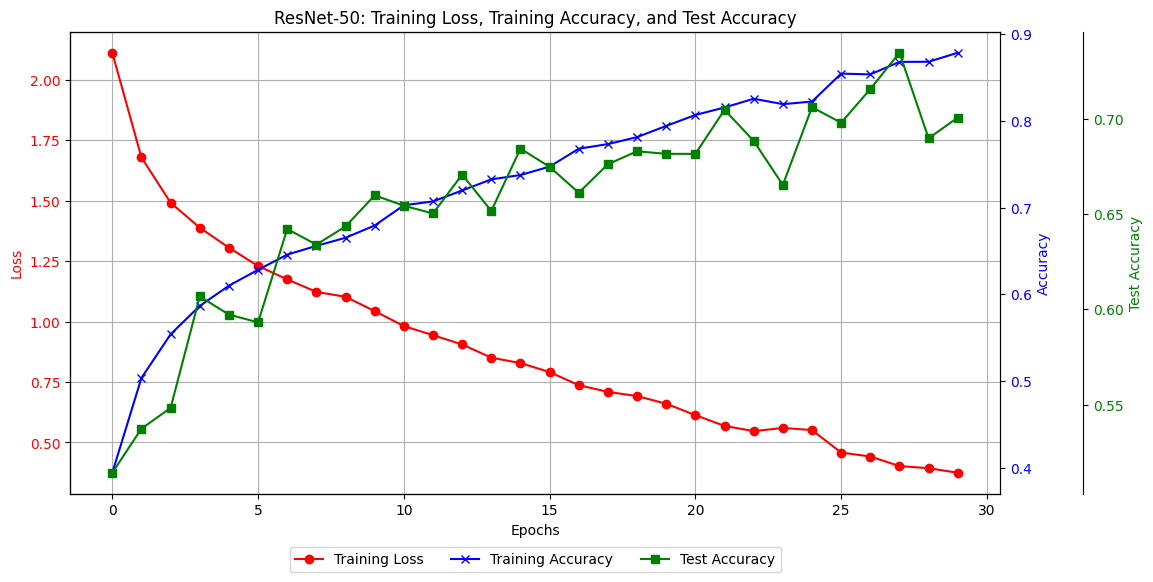

In [ ]:
train_acc = [acc.item() for acc in train_accuracies]
test_acc = [acc.item() for acc in test_acc_hist]
plot_metrics_acc(train_losses, train_acc, test_acc)

# Save logs

In [ ]:
import json

data = {
    "train_loss": train_losses,
    "train_accuracy": train_acc,
    "train_gap": train_gap,
    "test_accuracy": test_acc
}
LOG_FILE
with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)


In [ ]:
LOG_FILE

'/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_resnet-50.log'